## Exercise 4: Data Warehouse Querying and Basic Geospatial Operations

Skills: 
* Query data warehouse table
* Use dictionary to map values

References: 
* https://docs.calitp.org/data-infra/analytics_new_analysts/05-spatial-analysis-basics.html
* https://docs.calitp.org/data-infra/analytics_new_analysts/06-spatial-analysis-intro.html
* https://docs.calitp.org/data-infra/analytics_new_analysts/07-spatial-analysis-intermediate.html
* https://github.com/jorisvandenbossche/geopandas-tutorial

In [1]:
import geopandas as gpd
import pandas as pd
import os

#os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)
pd.set_option("display.max_rows", 20)

from calitp_data_analysis.tables import tbls
from calitp_data_analysis.sql import query_sql
from siuba import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_955/4198957771.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

## Query a table, turn it into a gdf

You will query the warehouse table for 2 operators, Caltrain and Merced. A `feed_key` is a hash identifier, there's no real meaning to it, but it uniquely identifies a feed for that day.

The `feed_key` values for those 2 operators for 6/1/2022 are provided. 

* Query `mart_gtfs.dim_stops`
* Filter to the feed keys of interest
* Select these columns: `feed_key`, `stop_id`, `stop_lat`, `stop_lon`, `stop_name`
* Return as a dataframe using `collect()`
* Turn the point data into geometry with `geopandas`: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)

In [4]:
#from 1mart_gtfs.dim_stops`, query the following columns, filtered by these specific `feed_id`s
FEEDS = [
    "25c6505166c01099b2f6f2de173e20b9", # Caltrain
    "52639f09eb535f75b33d2c6a654cb89e", # Merced
]

stops = (
    tbls.mart_gtfs.dim_stops()
    >> filter(_.feed_key.isin(FEEDS))
    >> select(_.feed_key, _.stop_id, 
             _.stop_lat, _.stop_lon, _.stop_name)
    >> arrange(_.feed_key, _.stop_id, 
               _.stop_lat, _.stop_lon)
    >> collect() 
)
stops.head()

/opt/conda/lib/python3.9/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_geom'
  sqlalchemy.util.warn(


,feed_key,stop_id,stop_lat,stop_lon,stop_name
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station


Turn the point data into geometry with geopandas

In [5]:
#got code ex from geopandas link
#creates geometry array of sahpely point geometries
geometry = gpd.points_from_xy(stops.stop_lon, stops.stop_lat, crs='EPSG:4326')
print(geometry)
type(geometry)

<GeometryArray>
[<POINT (-122.392 37.757)>, <POINT (-122.156 37.438)>,
 <POINT (-122.156 37.438)>, <POINT (-122.395 37.776)>,
 <POINT (-122.395 37.776)>, <POINT (-122.392 37.758)>,
 <POINT (-122.392 37.758)>,  <POINT (-122.402 37.71)>,
  <POINT (-122.402 37.71)>, <POINT (-122.405 37.656)>,
 ...
 <POINT (-120.645 36.976)>, <POINT (-120.637 36.986)>,
 <POINT (-120.628 36.982)>, <POINT (-120.625 36.983)>,
 <POINT (-120.629 36.987)>, <POINT (-120.626 36.992)>,
 <POINT (-120.572 37.362)>, <POINT (-120.504 37.292)>,
 <POINT (-120.722 37.391)>, <POINT (-120.823 37.058)>]
Length: 580, dtype: geometry


geopandas.array.GeometryArray

## Use a dictionary to map values

* Create a new column called `operator` where `feed_key` is associated with its operator name.
* First, write a function to do it.
* Then, use a dictionary to do it (create new column called `agency`).
* Double check that `operator` and `agency` show the same values. Use `assert` to check.
    * `assert df.operator == df.agency`
* Hint: https://docs.calitp.org/data-infra/analytics_new_analysts/02-data-analysis-intermediate.html

In [6]:
#COMPLETE
# function to create a new col (see ex1)
# define the function called `operator` that uses if..else to check the rows in `feed_key` col. 
# then on df `stops`, make a new column called `operator`, then fill the values in the new col by applying the operator function

def operator(row):
    if row.feed_key == '25c6505166c01099b2f6f2de173e20b9':
        return 'Caltrain'
    elif row.feed_key == '52639f09eb535f75b33d2c6a654cb89e':
        return 'Merced'
    else :
        return 'other'

stops['operator'] = stops.apply(operator,axis = 1)
stops.head()


,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,Caltrain
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,Caltrain
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,Caltrain
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,Caltrain


In [9]:
#COMPETE
#created dictionary called `feed_op` to map the feed keys to operator
#then used assign() to insert a new column, and map() to connect the dictionary to keed_key column
# df = df.assign(mode_cat = df.Mode.map(mode_fill))
feed_op = {
    '25c6505166c01099b2f6f2de173e20b9': 'Caltrain',
    '52639f09eb535f75b33d2c6a654cb89e': 'Merced',
}

stops_agency = stops.assign(agency = stops.feed_key.map(feed_op))
stops_agency.head()



,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,Caltrain,Caltrain
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,Caltrain,Caltrain
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,Caltrain,Caltrain
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,Caltrain,Caltrain


In [10]:
#createing a new dataframe `stops3` to be a geodataframe based on stops2
stops_gdf = gpd.GeoDataFrame(stops_agency)
type(stops_gdf)

geopandas.geodataframe.GeoDataFrame

In [11]:
# checking to see if operator and agency columns match using `asset` function
# example code: assert df.operator == df.agency

#not sure what going on...use () around the series.


#have to install shared utils using: install_env:
	# cd ~/data-analyses/_shared_utils && make setup_env && cd ..

assert (stops_agency.operator == stops_gdf.agency).all()

## Turn lat/lon into point geometry

* There is a [function in shared_utils](https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/geography_utils.py#L170-L192) that does it. Show the steps within the function (the long way), and also create the `geometry` column using `shared_utils`.
* Use `geography_utils.create_point_geometry??` to see what goes into that function, and what that function looks like under the hood.

In [12]:
# long way via function?
# define function
# reference code: geometry = gpd.points_from_xy(stops.stop_lon, stops.stop_lat, crs='EPSG:4326')
# then create new column in df

geo2 = gpd.points_from_xy(stops2.stop_lon, stops2.stop_lat, crs='EPSG:4326')

stops_gdf['geometry'] = geo2
stops_gdf.head()



/tmp/ipykernel_955/4222133737.py:8: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  stops_gdf['geometry'] = geo2


,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency,geometry
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain,POINT (-122.39249 37.75697)
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,Caltrain,Caltrain,POINT (-122.15641 37.43849)
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,Caltrain,Caltrain,POINT (-122.15648 37.43842)
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (-122.39499 37.77639)
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (-122.39494 37.77635)


In [13]:
type(stops_gdf)

geopandas.geodataframe.GeoDataFrame

In [14]:
#see lines L122-147 in `geopgraphy_utils.py`. function called 'create_point_geometry`
#how to call function from another python file!?
#copied example from another code snipped but, maybe im missing something
# have to install shared_utils first, see `Makefile` in data-analyses, use code: cd ~/data-analyses/_shared_utils && make setup_env && cd ..

from shared_utils import geography_utils


/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [15]:
from shared_utils import geography_utils
stops_ptg = geography_utils.create_point_geometry(
    stops_gdf,
    "stop_lon",
    "stop_lat",
    crs = "EPSG:3310"
)

In [16]:
type(stops_ptg)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

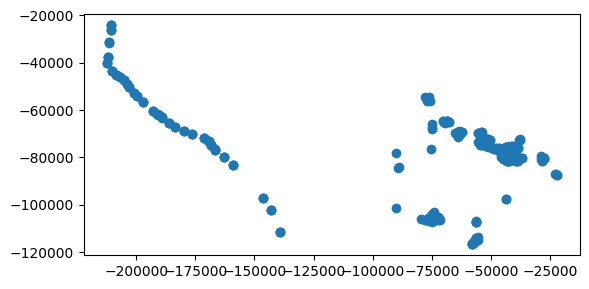

In [17]:
#creates plot using `stops3` gdf
stops_ptg.plot()

<AxesSubplot:>

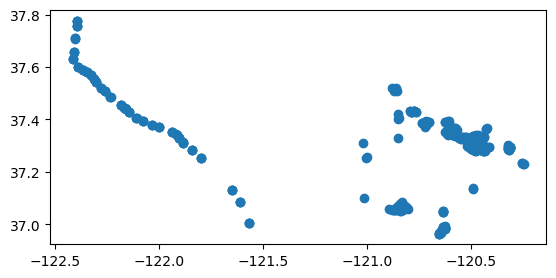

In [18]:
stops_ptg.to_crs("EPSG:4326").plot()

Basic stuff about a geodataframe.

A gdf would have a coordinate reference system that converts the points or lines into a place on the spherical Earth. The most common CRS is called `WGS 84`, and its code is `EPSG:4326`. This is what you'd see when you use Google Maps to find lat/lon of a place.

[Read](https://desktop.arcgis.com/en/arcmap/latest/map/projections/about-geographic-coordinate-systems.htm) about the `WGS 84` geographic coordinate system.

[Read](https://desktop.arcgis.com/en/arcmap/latest/map/projections/about-projected-coordinate-systems.htm) about projected coordinate reference systems, which is essentially about flattening our spherical Earth into a 2D plane so we can measure distances and whatnot.

* Is it a pandas dataframe or a geopandas geodataframe?: `type(gdf)`
* Coordinate reference system: `gdf.crs`
* gdfs must have a geometry column. Find the name of the column that is geometry: `gdf.geometry.name`
* Project the coordinate reference system to something else: `gdf = gdf.to_crs("EPSG:2229")` and check.

* This GitHub repo has several `geopandas` tutorials that covers basic spatial concepts: https://github.com/jorisvandenbossche/geopandas-tutorial. 
* Skim through the notebooks to see some of the concepts demonstrated, although to actually run the notebooks, you can click on `launch binder` in the repo's README to do so.

## Spatial Join (which points fall into which polygon)

This URL gives you CA county boundaries: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-county-boundaries/explore?location=37.246136%2C-119.002032%2C6.12

* Go to "I want to use this" > View API Resources > copy link for geojson
* Read in the geojson with `geopandas` and make it a geodataframe: `gpd.read_file(LONG_URL_PATH)`
* Double check that the coordinate reference system is the same for both gdfs using `gdf.crs`. If not, change it so they are the same.
* Spatial join stops to counties: [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html)
    * Play with inner join or left join, what's the difference? Which one do you want?
    * Play with switching around the left_df and right_df, what's the right order?
* By county: count number of stops and stops per sq_mi.
    * Hint 1: Start with a CRS with units in feet or meters, then do a conversion to sq mi. [CRS in shared_utils](https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/geography_utils.py)
    * Hint 2: to find area, you can create a new column and calculate `gdf.geometry.area`. [geometry manipulations docs](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html)

In [19]:
#read in file
#check df type for gdf

CA_county = gpd.read_file('https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/California_County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')
type(CA_county)

   OBJECTID COUNTY_NAME COUNTY_ABBREV  COUNTY_NUM COUNTY_CODE COUNTY_FIPS  \
0         1     Alameda           ALA           1          01         001   
1         2      Alpine           ALP           2          02         003   
2         3      Amador           AMA           3          03         005   
3         4       Butte           BUT           4          04         007   
4         5   Calaveras           CAL           5          05         009   

  ISLAND   Shape__Area  Shape__Length                              GlobalID  \
0    NaN  3.402787e+09  308998.650766  e6f92268-d2dd-4cfb-8b79-5b4b2f07c559   
1    NaN  3.146939e+09  274888.492411  870479b2-480a-494b-8352-ad60578839c1   
2    NaN  2.562635e+09  361708.438013  4f45b3a6-be10-461c-8945-6b2aaa7119f6   
3    NaN  7.339348e+09  526547.115238  44fba680-aecc-4e04-a499-29d69affbd4a   
4    NaN  4.351069e+09  370637.578323  d11ef739-4a1e-414e-bfd1-e7dcd56cd61e   

                                            geometry  
0  POLY

In [20]:
CA_county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
#change CRS of a gdf. 
#gdf.geometry.to_crs('EPSG:2229')
county2229 = CA_county.set_crs('EPSG:2229', allow_override=True)
county2229.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
#area of gdf, ensure CRS is not a decimal degrees. decimal degree isnt usable and cant create area

county2229.geometry.area

0     0.217411
1     0.198471
2     0.161961
3     0.455899
4     0.275908
        ...   
64    0.000059
65    0.000174
66    0.000041
67    0.014070
68    0.018707
Length: 69, dtype: float64

In [39]:
county2229.head()

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.271 37.905, -122.270 37.904, -1..."
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.587 38.714, -119.587 38.714, -1..."
2,3,Amador,AMA,3,03,005,NaN,2.562635e+09,361708.438013,4f45b3a6-be10-461c-8945-6b2aaa7119f6,"POLYGON ((-120.072 38.703, -120.072 38.685, -1..."
3,4,Butte,BUT,4,04,007,NaN,7.339348e+09,526547.115238,44fba680-aecc-4e04-a499-29d69affbd4a,"POLYGON ((-121.077 39.597, -121.079 39.585, -1..."
4,5,Calaveras,CAL,5,05,009,NaN,4.351069e+09,370637.578323,d11ef739-4a1e-414e-bfd1-e7dcd56cd61e,"POLYGON ((-120.018 38.436, -120.018 38.436, -1..."


In [46]:
county2229.geometry.area

0     0.217411
1     0.198471
2     0.161961
3     0.455899
4     0.275908
        ...   
64    0.000059
65    0.000174
66    0.000041
67    0.014070
68    0.018707
Length: 69, dtype: float64

In [44]:
stops2229 = stops_ptg.to_crs('EPSG:2229')
stops2229.crs


<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
stops2229.head()

,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency,geometry
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain,POINT (5290484.166 3218221.779)
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,Caltrain,Caltrain,POINT (5353967.719 3099309.691)
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,Caltrain,Caltrain,POINT (5353944.533 3099286.476)
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (5290070.611 3225326.968)
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (5290086.422 3225310.947)


In [43]:
stops2229.geometry.area

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
575    0.0
576    0.0
577    0.0
578    0.0
579    0.0
Length: 580, dtype: float64

In [33]:
# inner join
geojoin_in = gpd.sjoin(county2229, stops2229, how='inner')

print(type(geojoin_in))
print(geojoin_in.shape)
print(geojoin_in.feed_key.isna().value_counts())
print(geojoin_in.OBJECTID.isna().value_counts())
geojoin_in.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(0, 19)
Series([], Name: feed_key, dtype: int64)
Series([], Name: OBJECTID, dtype: int64)


,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry,index_right,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency


In [34]:
#Play with inner join or left join, what's the difference? Which one do you want?
#LEFT join
geojoin_lf = gpd.sjoin(county2229, stops2229, how='left')
print(type(geojoin_lf))
print(geojoin_lf.shape)
print(geojoin_lf.feed_key.isna().value_counts())
print(geojoin_lf.OBJECTID.isna().value_counts())
geojoin_lf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(69, 19)
True    69
Name: feed_key, dtype: int64
False    69
Name: OBJECTID, dtype: int64


,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID,geometry,index_right,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency
0,1,Alameda,ALA,1,01,001,NaN,3.402787e+09,308998.650766,e6f92268-d2dd-4cfb-8b79-5b4b2f07c559,"POLYGON ((-122.271 37.905, -122.270 37.904, -1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Alpine,ALP,2,02,003,NaN,3.146939e+09,274888.492411,870479b2-480a-494b-8352-ad60578839c1,"POLYGON ((-119.587 38.714, -119.587 38.714, -1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Amador,AMA,3,03,005,NaN,2.562635e+09,361708.438013,4f45b3a6-be10-461c-8945-6b2aaa7119f6,"POLYGON ((-120.072 38.703, -120.072 38.685, -1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Butte,BUT,4,04,007,NaN,7.339348e+09,526547.115238,44fba680-aecc-4e04-a499-29d69affbd4a,"POLYGON ((-121.077 39.597, -121.079 39.585, -1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Calaveras,CAL,5,05,009,NaN,4.351069e+09,370637.578323,d11ef739-4a1e-414e-bfd1-e7dcd56cd61e,"POLYGON ((-120.018 38.436, -120.018 38.436, -1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inner vs Left Join compare

Inner join for `county2229` and `stops2229` returned nothing. Whereas, left join of `county2229` and `stops2229` actually had data.


In [35]:
#Play with switching around the left_df and right_df, what's the right order?
# initial join geojoin = gpd.sjoin(stops2, CA_county, how='left')

geojoin_stp_cnty = gpd.sjoin(stops2229, county2229, how='left')
print(type(geojoin_stp_cnty))
print(geojoin_stp_cnty.shape)
print(geojoin_stp_cnty.feed_key.isna().value_counts())
print(geojoin_stp_cnty.OBJECTID.isna().value_counts())
geojoin_stp_cnty.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(580, 19)
False    580
Name: feed_key, dtype: int64
True    580
Name: OBJECTID, dtype: int64


,feed_key,stop_id,stop_lat,stop_lon,stop_name,operator,agency,geometry,index_right,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,Shape__Area,Shape__Length,GlobalID
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,Caltrain,Caltrain,POINT (-210476.178 -26180.127),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,Caltrain,Caltrain,POINT (-190515.741 -62073.320),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,Caltrain,Caltrain,POINT (-190522.657 -62080.530),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (-210641.541 -24016.628),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,Caltrain,Caltrain,POINT (-210636.647 -24021.422),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Swapping left/right gdf

initial left join of `geojoin_lf` had 69 rows as opposed to to `geojoin_stp_cnty` where Stops are on the left joined in by counties on the right had 580 rows. Also, geometry changed from Polygon to point respectively. 

### What's the right order?
I would think that `geojoin_stp_cnty` is the correct order to have, however i would want to change to geometry type to polygon




### Next

By county: count number of stops and stops per sq_mi.
* Hint 1: Start with a CRS with units in feet or meters, then do a conversion to sq mi. CRS in shared_utils
* Hint 2: to find area, you can create a new column and calculate `gdf.geometry.area`. geometry manipulations docs

In [37]:
#took too long tying to remember the syntax before giving up and looking it up
#syntax structure explained. 1.name of df 2.groupby function 3.column to groupby 4. column to keep. 5.count by

# of stops per country
stop_count = geojoin_stp_cnty.groupby('COUNTY_NAME')['stop_id'].count().reset_index()
stop_count

,COUNTY_NAME,stop_id


In [ ]:
# stuck on getting stops per sq_mi

# get sq mi first, 
#make a new col need to convert miles to square miles
#then new col to divide... by....

WGS84 = "EPSG:4326"
CA_StatePlane = "EPSG:2229"  # units are in feet
CA_NAD83Albers = "EPSG:3310"  # units are in meters

SQ_MI_PER_SQ_M = 3.86 * 10**-7
FEET_PER_MI = 5_280
SQ_FT_PER_SQ_MI = 2.788 * 10**7


In [ ]:
#new gdf with new CRS that is in feet.
geojoin_ft=geojoin.set_crs(CA_StatePlane, allow_override=True)

geojoin_ft.crs


In [ ]:
geojoin.head()

In [ ]:
geojoin_ft.geometry.area